# Training a CNN with Text Supervision

In [1]:
import torch
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
from instadata import InstaData
from pathlib import Path

torch.cuda.is_available()

True

## Load datasets

In [2]:
batch_size = 64
workers = 12
train_dataset = InstaData("train")
val_dataset = InstaData("validate")
test_dataset = InstaData("test")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers,pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=workers,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=workers,pin_memory=True)

In [26]:
print(f"train, val, test datasets: {len(train_dataset)}, {len(val_dataset)}, {len(test_dataset)}")

train, val, test datasets: 800010, 49990, 126513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Size of an image: torch.Size([3, 224, 224])


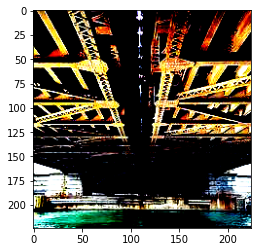

In [27]:
import matplotlib.pyplot as plt
_, img, caption = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))

In [30]:
print(f"Size of an image: {img.shape}")
torch.unsqueeze(img, 0).shape

Size of an image: torch.Size([3, 224, 224])


torch.Size([1, 3, 224, 224])

In [36]:
model = models.resnet50(pretrained=True)
v = next(iter(val_loader))

In [46]:
v[2].shape

torch.Size([64, 20])

## Train model

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
model.fc = nn.Linear(model.fc.in_features, 20)

model_ft = model_ft.to(device)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [3, 224, 224] instead

In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model